In [3]:
ls -ltrh ../Data/ice

total 36928
-rw-rw-rw-  1 bogdan  staff   2.2M Oct 24 04:58 N_seaice_extent_daily_v3.0.csv
-rw-rw-rw-  1 bogdan  staff   2.2M Oct 24 05:03 S_seaice_extent_daily_v3.0.csv
-rw-rw-rw-@ 1 bogdan  staff   3.2M Oct 24 05:05 Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
-rw-r--r--@ 1 bogdan  staff   4.6M Nov 29 12:28 ice_final.csv
-rw-r--r--  1 bogdan  staff   5.8M Dec 29 18:13 ice_and_co2.csv


In [4]:
ls -ltrh ../Data/co2

total 432
-rw-r--r--@ 1 bogdan  staff    48K Nov 11 14:44 monthly_in_situ_co2.csv
-rw-r--r--@ 1 bogdan  staff    29K Nov 21 11:58 co2_mm_mlo.csv
-rw-r--r--@ 1 bogdan  staff    27K Nov 23 13:18 CO2_final.csv
-rw-r--r--@ 1 bogdan  staff    71K Nov 27 11:35 CO2_0000-2014.csv
-rw-r--r--@ 1 bogdan  staff    27K Dec  1 07:44 CO2_final_November.csv
-rw-r--r--@ 1 bogdan  staff   634B Dec 29 17:49 CO2_diff.csv


In [5]:
ls -ltrh ../Data/fire/*.csv

-rw-r--r--@ 1 bogdan  staff    50M Nov 24 05:56 ../Data/fire/fire_M6_final.csv
-rw-r--r--@ 1 bogdan  staff    85M Nov 24 06:03 ../Data/fire/fire_V1_final.csv


In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import random
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import norm, poisson, t
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

In [7]:
# Load fire data
fire_M6=pd.read_csv('../Data/fire/fire_M6_final.csv', index_col = False)
fire_V1=pd.read_csv('../Data/fire/fire_V1_final.csv', index_col = False)

In [8]:
fire_M6.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2000-11-01,26.8,-20.8650,146.3039,0.01181,317.00,True,False,False
1,2000-11-01,68.8,-20.5602,146.0194,0.01181,319.95,False,True,False
2,2000-11-01,7.1,-24.3197,151.5619,0.01250,311.15,False,True,False


In [9]:
fire_V1.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2012-01-31,0.9,11.81456,4.97983,0.05208,298.45,False,True,False
1,2012-01-31,1.3,10.39675,13.45527,0.05208,302.25,False,True,False
2,2012-01-31,1.9,13.73985,13.83765,0.05208,301.80,False,True,False


In [10]:
# Load CO2 data
CO2=pd.read_csv('../Data/co2/CO2_final.csv', index_col = False)
CO2.head(3)

,Year,Month,decimal_date,CO2_ppm,trend
0,1958,3,1958.208,315.71,314.62
1,1958,4,1958.292,317.45,315.29
2,1958,5,1958.375,317.50,314.71


In [11]:
CO2_diff = pd.read_csv('../Data/co2/CO2_diff.csv', index_col = False)
CO2_diff.columns = ['Year', 'CO2_difference']
CO2_diff.head(3)

,Year,CO2_difference
0,1958,4.84
1,1959,5.03
2,1960,6.20


In [12]:
# Load ice data
ice=pd.read_csv('../Data/ice/ice_final.csv', index_col = False)
ice = ice.set_index('Unnamed: 0')
ice.index.name = None
# use shorter names
ice.columns = ['Baffin', 'Baffin-ext', 'Barents-ext', 'Beaufort', 'Barents', 'Beaufort-ext',
'Bering', 'Bering-ext', 'Canadian', 'Canadian-ext', 'Central-Arctic', 'Central-Arctic-ext',
'Chukchi', 'Chukchi-ext', 'East-Siberian', 'East-Siberian-ext', 'Greenland', 'Greenland-ext',
'Hudson', 'Hudson-ext', 'Kara', 'Kara-ext', 'Laptev', 'Laptev-ext', 'Okhotsk', 'Okhotsk-ext',
'St-Lawrence', 'St-Lawrence-ext', 'North_ext', 'South_ext']
ice.head(3)

,Baffin,Baffin-ext,Barents-ext,Beaufort,Barents,Beaufort-ext,Bering,Bering-ext,Canadian,Canadian-ext,...,Kara,Kara-ext,Laptev,Laptev-ext,Okhotsk,Okhotsk-ext,St-Lawrence,St-Lawrence-ext,North_ext,South_ext
1978-10-28,416908.720,521862.289,222781.361,361743.416,895310.805,940219.39,11472.805,35555.883,719220.320,761228.252,...,569610.622,815398.750,802884.363,872414.226,16799.581,35135.582,0.0,0.0,10.4200,17.8030
1978-10-29,416908.720,521862.289,222781.361,361743.416,895310.805,940219.39,11472.805,35555.883,719220.320,761228.252,...,569610.622,815398.750,802884.363,872414.226,16799.581,35135.582,0.0,0.0,10.4885,17.7365
1978-10-30,419829.102,531533.703,229769.256,379395.172,894088.098,940219.39,13553.099,42670.305,717303.629,761228.252,...,562328.391,816017.367,806760.991,872414.226,18745.308,39102.698,0.0,0.0,10.5570,17.6700


Statistical Data Analysis

CO2

The latest 20 years show an acceleration of the historical trend as shown below

In [13]:
sns.set_style("whitegrid")
sns.set_context("poster")

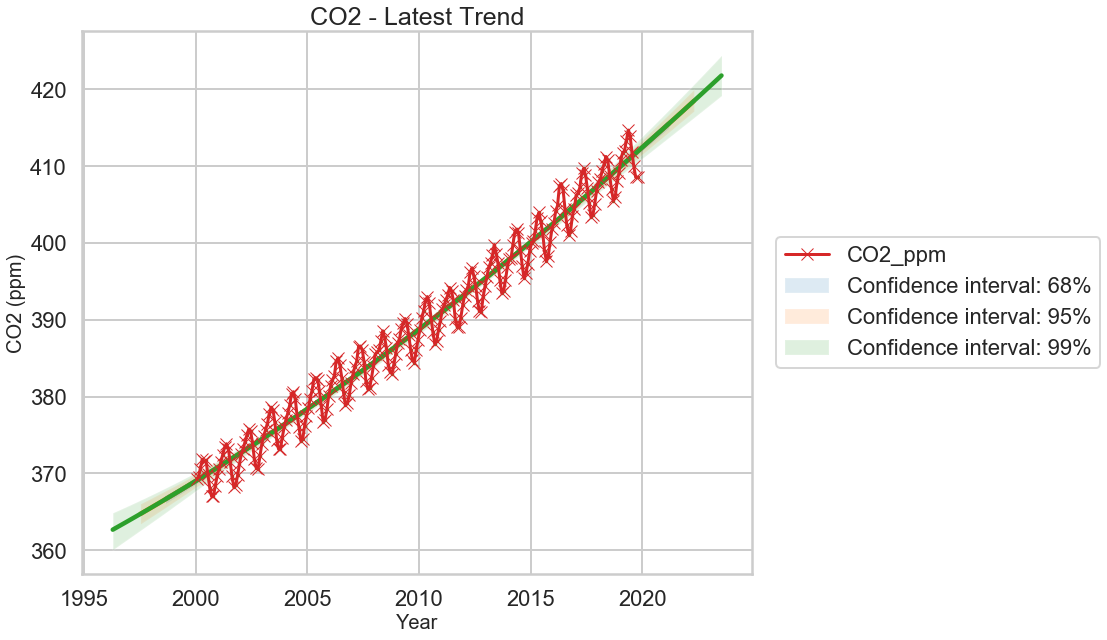

In [14]:
sd = {"sd1": 68.27, "sd2": 95.45, "sd3": 99.73}
detail_df=CO2[502:]
fig = plt.figure(figsize=(12, 10))
for sd_item in sd.keys():
    ax = sns.regplot(x='decimal_date', y='CO2_ppm', ci=sd[sd_item], data=detail_df, order=2, scatter_kws={'s':5})
plt.plot('decimal_date', 'CO2_ppm', data=detail_df, linestyle='-', marker='x')
plt.title('CO2 - Latest Trend', fontsize=25); plt.xlabel('Year', fontsize=20); plt.ylabel('CO2 (ppm)', fontsize=20)
ax.collections[1].set_label('Confidence interval: 68%')
ax.collections[3].set_label('Confidence interval: 95%')
ax.collections[5].set_label('Confidence interval: 99%')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
plt.show()

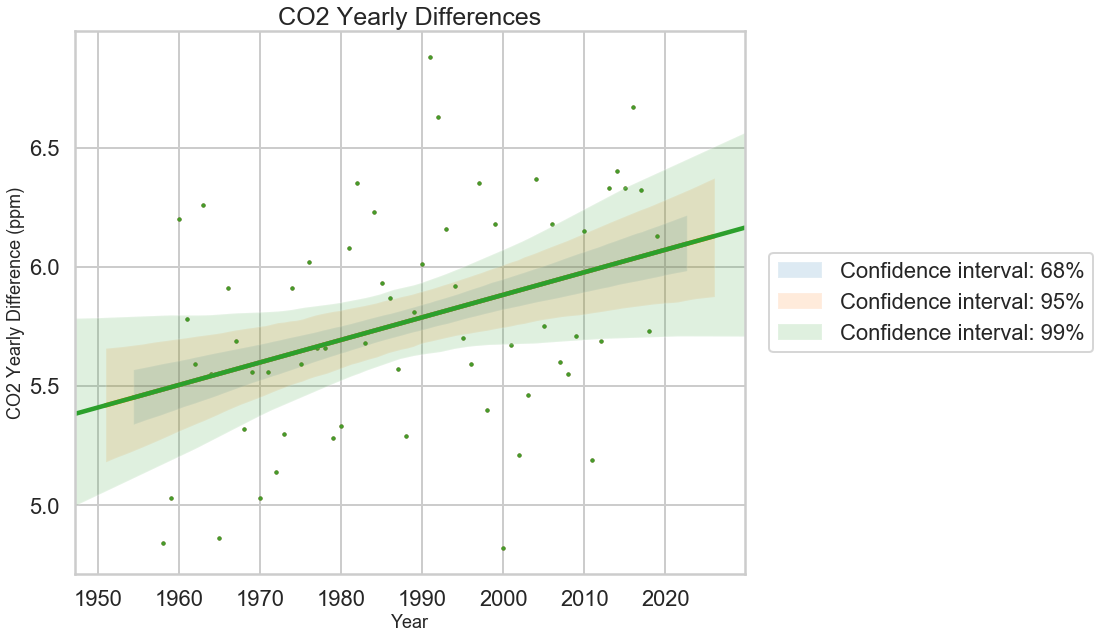

In [15]:
sd = {"sd1": 68.27, "sd2": 95.45, "sd3": 99.73}
fig = plt.figure(figsize=(12, 10))
for sd_item in sd.keys():
    ax = sns.regplot(x='Year', y='CO2_difference', data=CO2_diff, ci=sd[sd_item], order=1, scatter_kws={'s':10})
plt.title('CO2 Yearly Differences', fontsize=25)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 Yearly Difference (ppm)', fontsize=18)
ax.collections[1].set_label('Confidence interval: 68%')
ax.collections[3].set_label('Confidence interval: 95%')
ax.collections[5].set_label('Confidence interval: 99%')
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
plt.show()

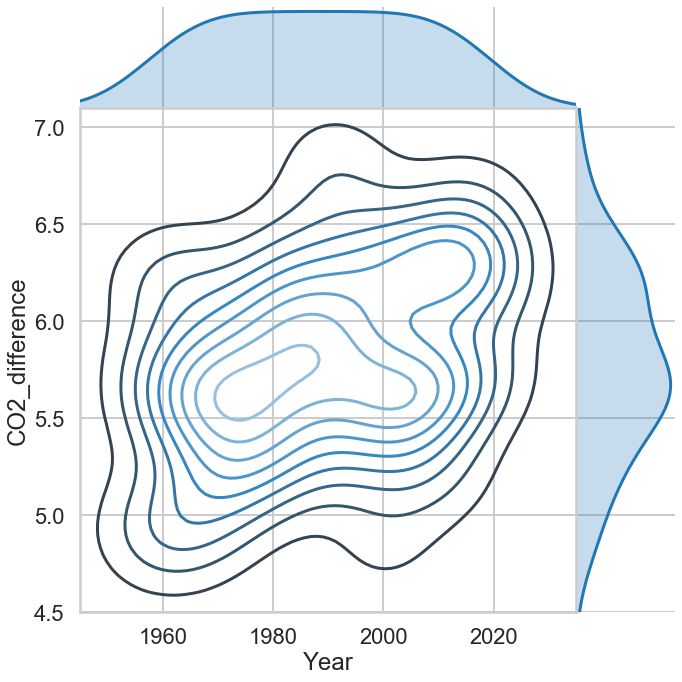

In [16]:
g = sns.JointGrid(x='Year', y='CO2_difference', data=CO2_diff, height=10, xlim=(1945,2035), ylim=(4.5,7.1), space=0)
#g = g.plot(sns.regplot, sns.distplot)

g = g.plot_joint(sns.kdeplot, cmap="Blues_d")
g = g.plot_marginals(sns.kdeplot, shade=True)

In [17]:
CO2_lm = ols('CO2_difference ~ Year', CO2_diff).fit()

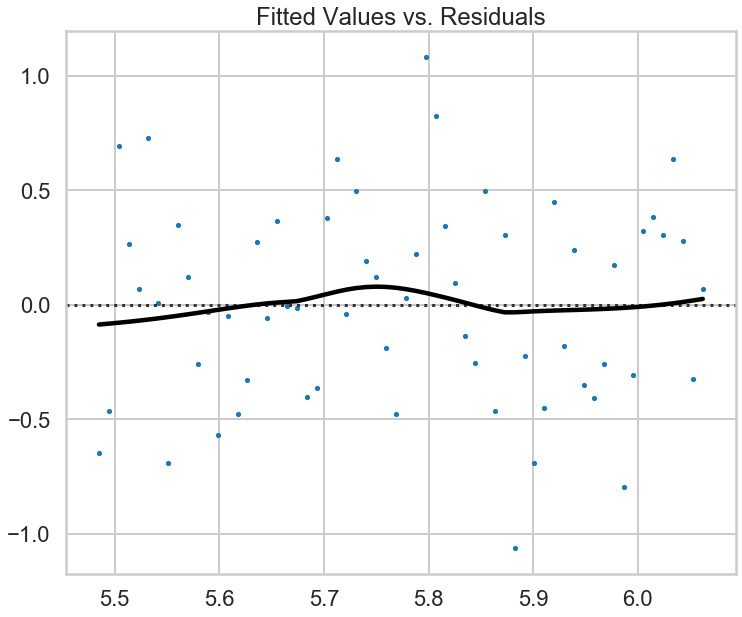

In [18]:
plt.figure(figsize=(12, 10))
plt.scatter(CO2_lm.fittedvalues, CO2_lm.resid, s=10)
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Fitted Values vs. Residuals")
sns.residplot(CO2_lm.fittedvalues, CO2_lm.resid, lowess=True, 
              scatter_kws={"s": 10},
              line_kws={'color': 'black'})

In [19]:
# The residuals plot looks good, with minor differences around zero on the y axis.
# However, the strange behaviour from the years 1990...1995 is translated here 
# by the behaviour of the residuals around 5.75...5.85 CO2 ppm yearly difference

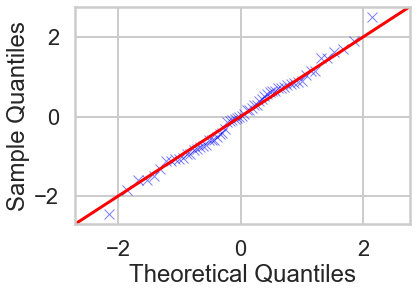

In [20]:
res = CO2_lm.resid # residuals
fig = sm.qqplot(res, fit=True, line='45', marker='x', markersize=10, alpha=0.5)
plt.show()

In [21]:
# Since the quantiles aliniate more or less around the line, 
# the distribution is close to a normal distribution

In [22]:
CO2_diff['period']=np.NaN
CO2_diff.loc[CO2_diff.Year<=1990, 'period']='before 1990'
CO2_diff.loc[(CO2_diff.Year>1990) & (CO2_diff.Year<=1995), 'period']='1990...1995'
CO2_diff.loc[CO2_diff.Year>1995, 'period']='after 1995'

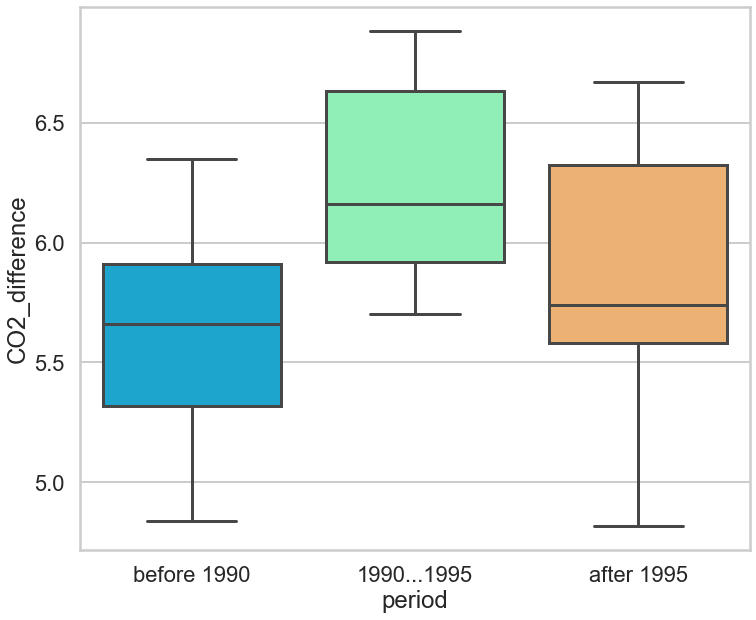

In [23]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=CO2_diff, x='period', y='CO2_difference', palette='rainbow')
#sns.boxplot(data=titanic, x='class', y='age', palette='rainbow')

In [24]:
def ecdf(data):
    """
    Compute ECDF for a one-dimensional array of measurements.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    return x,y

Text(0, 0.5, 'Number of Years')

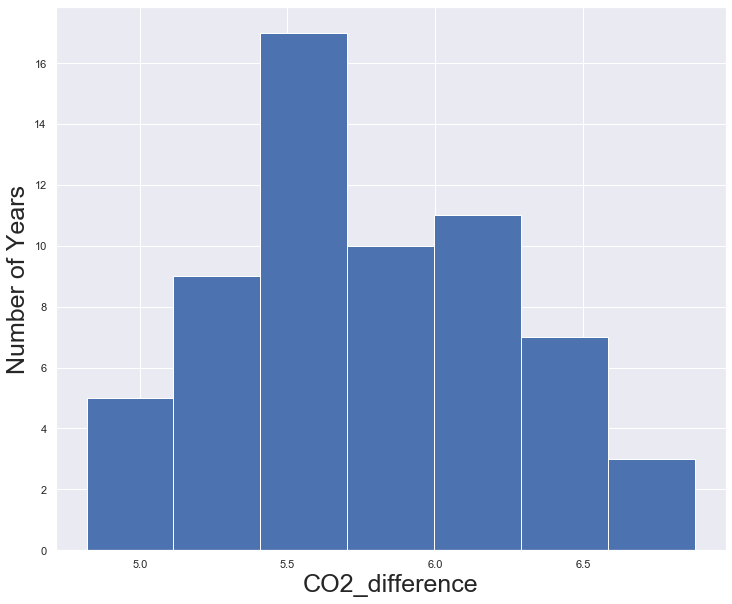

In [25]:
sns.set()
fig = plt.figure(figsize=(12, 10))
plt.hist(CO2_diff['CO2_difference'], bins=int(np.sqrt(len(CO2_diff))))
plt.xlabel('CO2_difference', size=25)
plt.ylabel('Number of Years', size=25)

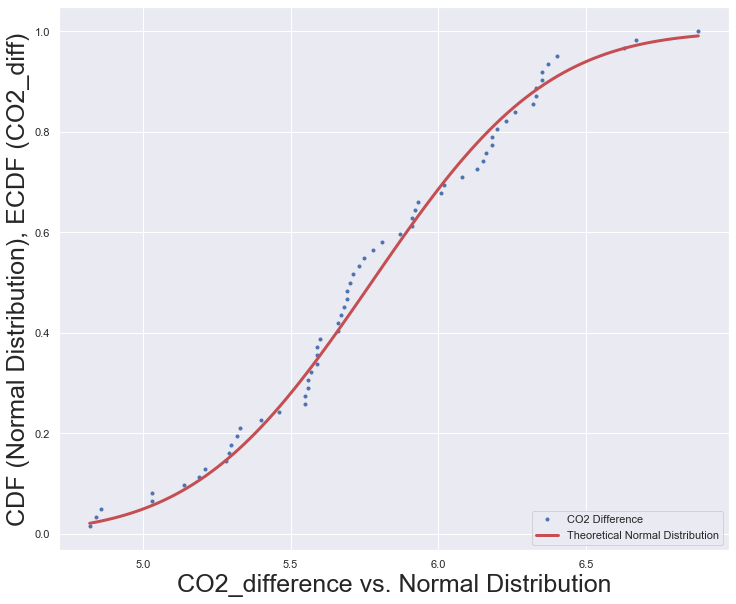

In [26]:
fig = plt.figure(figsize=(12, 10))
x, y = ecdf(CO2_diff['CO2_difference'])
xn = np.linspace(CO2_diff['CO2_difference'].min(), CO2_diff['CO2_difference'].max(), 100)
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(xn, norm.cdf(xn,loc=CO2_diff['CO2_difference'].mean(),scale=CO2_diff['CO2_difference'].std()), 'r-', lw=3)
plt.xlabel('CO2_difference vs. Normal Distribution', size=25)
plt.ylabel('CDF (Normal Distribution), ECDF (CO2_diff)', size=25)
plt.legend(('CO2 Difference', 'Theoretical Normal Distribution'), loc='lower right')
plt.show()

It looks like the CO2 difference after 1995 is higher than before 1990, but the mean is similar. 
The distribution looks normal because the CO2 difference points align well
with the theoretical normal distribution

However, it looks like the 1990...1995 period is special from the point of view of mean.

Hypothesis:

H0: the CO2 yearly distribution before 1990 is the same with the CO2 yearly distribution after 1995

H1: the distributions are different

We want to check if the H0 hypothesis can be safely rejected or not.

Text(0.5, 1.0, 'Boxplots: 1958 - 2019')

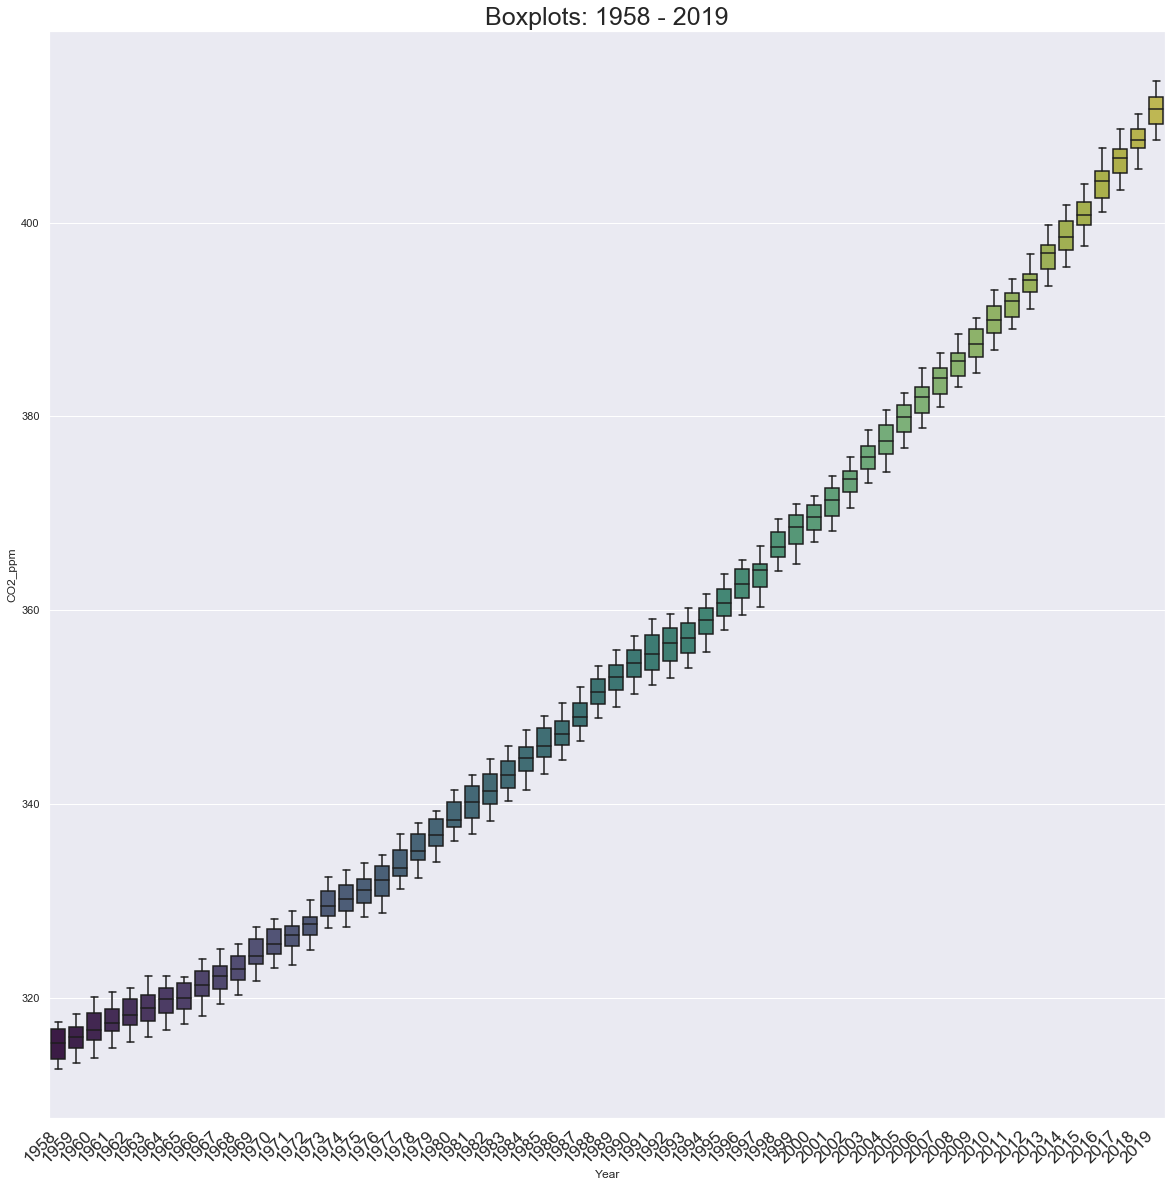

In [68]:
# boxplots, grouped by year
plt.figure(figsize=(20,20))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
sns.boxplot(x="Year", y="CO2_ppm", data=CO2, palette='viridis', saturation=0.5)
plt.title('Boxplots: 1958 - 2019', fontsize=25)

The anomaly around 1990...1995 is clearly visible in the diagram above.

Text(0.5, 1, 'Order 1 polynomial interpolation')

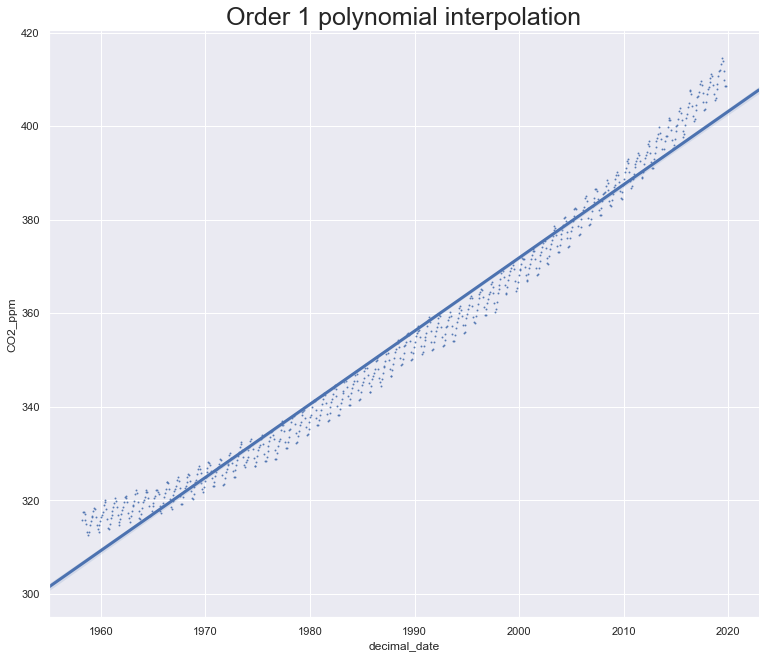

In [27]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=1,
           scatter_kws={"s": 1}, line_kws={"lw": 3})
plt.title('Order 1 polynomial interpolation', fontsize=25)

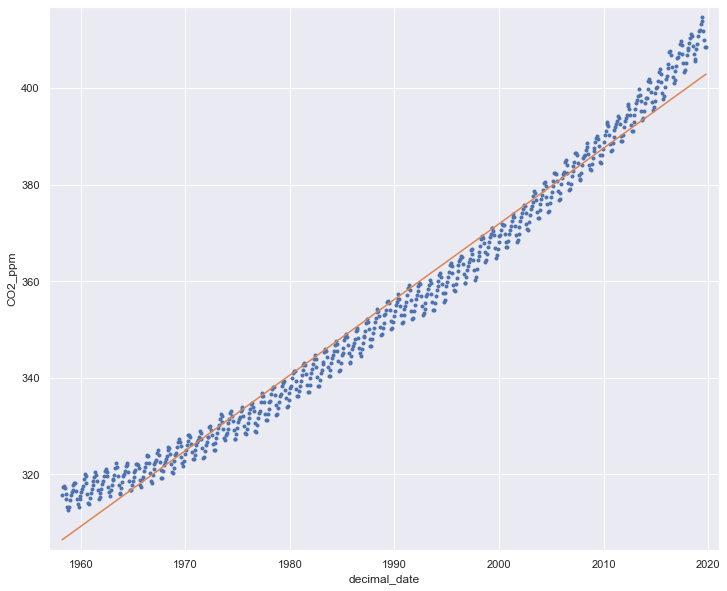

In [28]:
# Do the same thing with numpy polyfit
slope, intercept = np.polyfit(x=CO2['decimal_date'], y=CO2['CO2_ppm'], deg=1)

fig = plt.figure(figsize=(12, 10))
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'], marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('decimal_date')
plt.ylabel('CO2_ppm')

x = np.array([CO2['decimal_date'].min(), CO2['decimal_date'].max()])
y = slope * x + intercept
plt.plot(x, y)
plt.show()

This diagram is exactly as the one shown before, but we can have access to intercept and coefficient(s) - and other values if required

A simple order 1 regression is obviousely not a good fit for the data; will check with order 2

Text(0.5, 1, 'Order 2 polynomial interpolation')

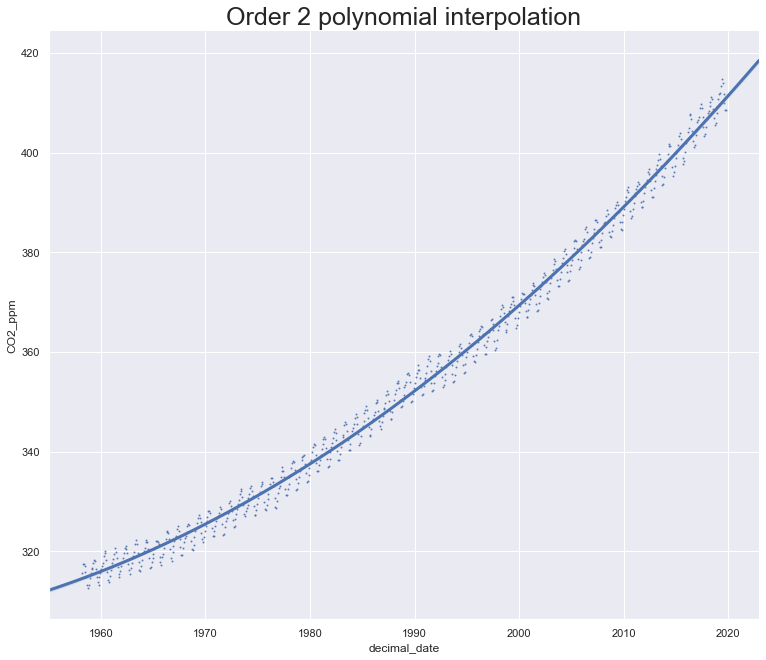

In [29]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=2,
           scatter_kws={"s": 1}, line_kws={"lw": 3})
plt.title('Order 2 polynomial interpolation', fontsize=25)

Order2:
coef2= 0.012820604397593428, coef1= -49.434577079439194, intercept= 47956.09076994939

Order3:
coef3= 1.889411378202316e-05, coef2= -0.09992057253972854, coef1= 174.7968463759105, intercept= -100695.0520517845



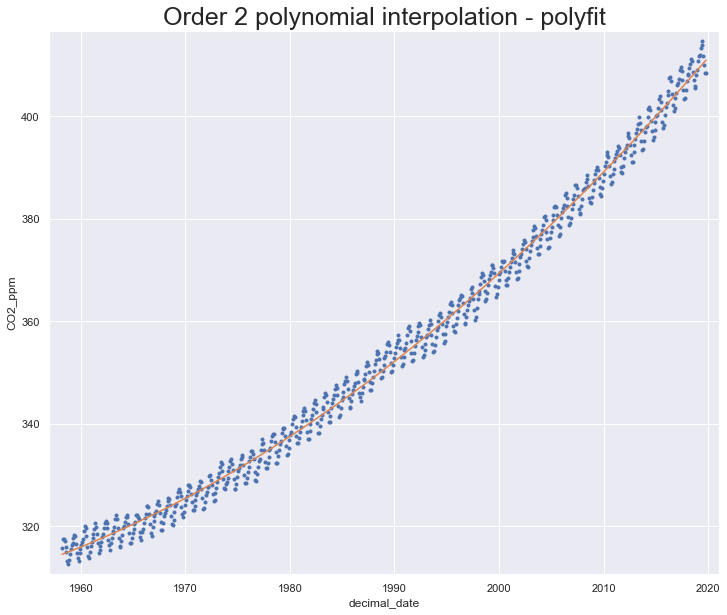

In [30]:
# Do the same thing with numpy polyfit, order 2 and order 3
coef2_2, coef1_2, intercept_2 = np.polyfit(x=CO2['decimal_date'], y=CO2['CO2_ppm'], deg=2)
print("Order2:\ncoef2= {}, coef1= {}, intercept= {}\n".format(coef2_2, coef1_2, intercept_2))
coef3_3, coef2_3, coef1_3, intercept_3 = np.polyfit(x=CO2['decimal_date'], y=CO2['CO2_ppm'], deg=3)
print("Order3:\ncoef3= {}, coef2= {}, coef1= {}, intercept= {}\n".format(coef3_3, coef2_3, coef1_3, intercept_3))

fig = plt.figure(figsize=(12, 10))
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'], marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('decimal_date')
plt.ylabel('CO2_ppm')

x = np.array(CO2['decimal_date'])
y = np.array(coef2_2 * x**2 + coef1_2 * x + intercept_2)
plt.plot(x,y)
plt.title('Order 2 polynomial interpolation - polyfit', fontsize=25)
plt.show()

It looks like order 2 is a much better fit. An order 3 polynomial interpolation adds only marginal adjustments as shown below and may prove to be an overfit due to the 1995...2000 anomaly. The order 3 coefficient is very small. That anomaly is unlikely to be repeated in the future so order 2 polynomial fit is the most logical approach.

Text(0.5, 1, 'Order 3 polynomial interpolation')

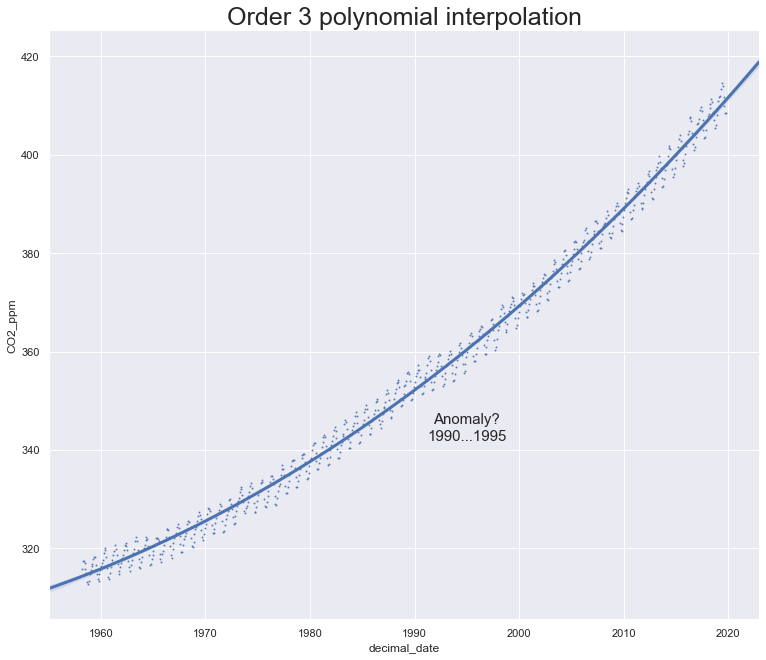

In [31]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=3,
           scatter_kws={"s": 1}, line_kws={"lw": 3})
plt.text(1995, 342, 'Anomaly?\n1990...1995', horizontalalignment='center', fontsize=15)
plt.title('Order 3 polynomial interpolation', fontsize=25)

Order2, until 1990:
coef2= 0.019902917644473894, coef1= -77.36222388645258, intercept= 75487.29890566519



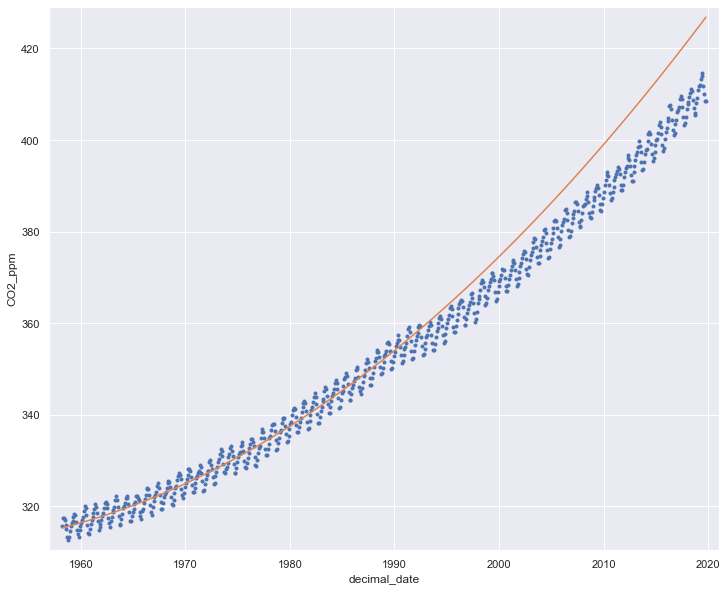

In [32]:
# Create the order 2 polynomial model for a subset of CO2 data starting from the beginning until 1990 
# and extrapolate it for all the CO2 data

CO2_until_1990 = CO2[CO2['decimal_date'] <= 1990]
coef2_1990, coef1_1990, intercept_1990 = np.polyfit(x=CO2_until_1990['decimal_date'], 
                                                    y=CO2_until_1990['CO2_ppm'], 
                                                    deg=2)
print("Order2, until 1990:\ncoef2= {}, coef1= {}, intercept= {}\n".format(coef2_1990, coef1_1990, intercept_1990))

fig = plt.figure(figsize=(12, 10))
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'], marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('decimal_date')
plt.ylabel('CO2_ppm')

x = np.array(CO2['decimal_date'])
y = np.array(coef2_1990 * x**2 + coef1_1990 * x + intercept_1990)
plt.plot(x,y)
plt.show()

It is obvious that there is an anomaly around 1990...1995 but we need solid proof for rejecting H0

In [33]:
def draw_bs_pairs_polyfit2(x, y, size=1):
    """Perform pairs bootstrap for order 2 polynomial regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_coef2_2_reps = np.empty(size)
    bs_coef1_2_reps = np.empty(size)
    bs_intercept_2_reps = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_coef2_2_reps[i], bs_coef1_2_reps[i], bs_intercept_2_reps[i] = np.polyfit(bs_x, bs_y, 2)

    return bs_coef2_2_reps, bs_coef1_2_reps, bs_intercept_2_reps

Order2 1000 bootstrap replicates, until 1990:
coef2= [0.01718401 0.02252439]
coef1= [-87.70709151 -66.62481846]
intercept= [64890.58373121 85692.60011751]



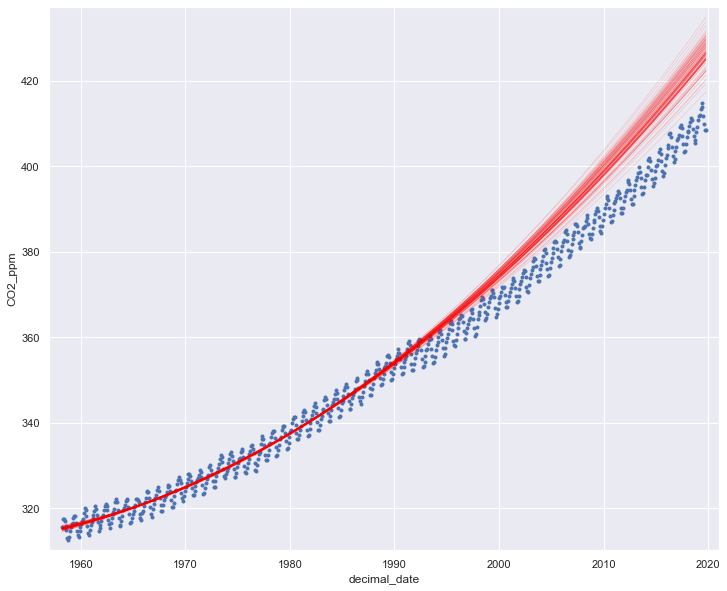

In [34]:
# Generate 1000 replicates of intercept of coefficients for order 2 polyfit, using pairs bootstrap
bs_coef2_2_1990_reps, bs_coef1_2_1990_reps, bs_intercept_2_1990_reps = \
draw_bs_pairs_polyfit2(CO2_until_1990['decimal_date'], CO2_until_1990['CO2_ppm'], size=1000)

# Compute and print 95% CI for slope
print("Order2 1000 bootstrap replicates, until 1990:\ncoef2= {}\ncoef1= {}\nintercept= {}\n".format(
    np.percentile(bs_coef2_2_1990_reps, [2.5, 97.5]), 
    np.percentile(bs_coef1_2_1990_reps, [2.5, 97.5]), 
    np.percentile(bs_intercept_2_1990_reps, [2.5, 97.5])))

# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Show the scatterplot
fig = plt.figure(figsize=(12, 10))
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'], marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('decimal_date')
plt.ylabel('CO2_ppm')

# Plot the bootstrap lines
for i in range(100):
    x = np.array(CO2['decimal_date'])
    y = np.array(bs_coef2_2_1990_reps[i] * x**2 + bs_coef1_2_1990_reps[i] * x + bs_intercept_2_1990_reps[i])
    _ = plt.plot(x, y, linewidth=0.5, alpha=0.2, color='red')

plt.show()

Even from 1990 the fit starts to look bad but from 2000 there is no fit at all.

From the 1000 models I select the bootstrap replicate that has the lowest "y" around 2020

In [35]:
x = max(CO2['decimal_date'])
bs_models = pd.DataFrame()
bs_models['coef2'] = bs_coef2_2_1990_reps
bs_models['coef1'] = bs_coef1_2_1990_reps
bs_models['intercept'] = bs_intercept_2_1990_reps
bs_models['y'] = bs_coef2_2_1990_reps * x**2 + bs_coef1_2_1990_reps * x + bs_intercept_2_1990_reps

In [41]:
ind = np.argmin(np.array(bs_models['y']))
print("min=", bs_models['y'].min(), ' index=', ind)

min= 417.39499318280286  index= 98


In [67]:
print(CO2['CO2_ppm'].tail(24), '\n', 
      CO2['CO2_ppm'].tail(24).min(), '\n', 
      CO2['CO2_ppm'].tail(24).max(), '\n',
      CO2_diff.tail(2))

716    405.12
717    406.81
718    407.96
719    408.32
720    409.41
721    410.24
722    411.24
723    410.79
724    408.71
725    406.99
726    405.51
727    406.00
728    408.02
729    409.07
730    410.83
731    411.75
732    411.97
733    413.32
734    414.66
735    413.92
736    411.77
737    409.95
738    408.54
739    408.53
Name: CO2_ppm, dtype: float64 
 405.12 
 414.66 
     Year  CO2_difference      period
60  2018            5.73  after 1995
61  2019            6.13  after 1995


In [ ]:
# The quadratic regression estimates 417.39 ppm for the last observation while the CO2 concentration varied
# between 405.12 ppm and 414.66 ppm within the last two years, with 
# a yearly CO2 difference of 5.73 ppm in 2018 and 6.13 ppm in 2019

In [42]:
coef2, coef1, intercept = bs_models['coef2'][ind], bs_models['coef1'][ind], bs_models['intercept'][ind]
print(coef2, coef1, intercept)

0.015191362681415892 -58.76110419172254 57128.531814190384


In [43]:
bs_models.loc[ind]

coef2            0.015191
coef1          -58.761104
intercept    57128.531814
y              417.394993
Name: 98, dtype: float64

In [46]:
# permutation sample
CO2_perm = np.random.permutation(CO2['CO2_ppm'])

In [47]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [48]:
perm_sample_1, perm_sample_2 = permutation_sample(CO2_perm[:len(CO2_until_1990)], CO2_perm[len(CO2_until_1990):])

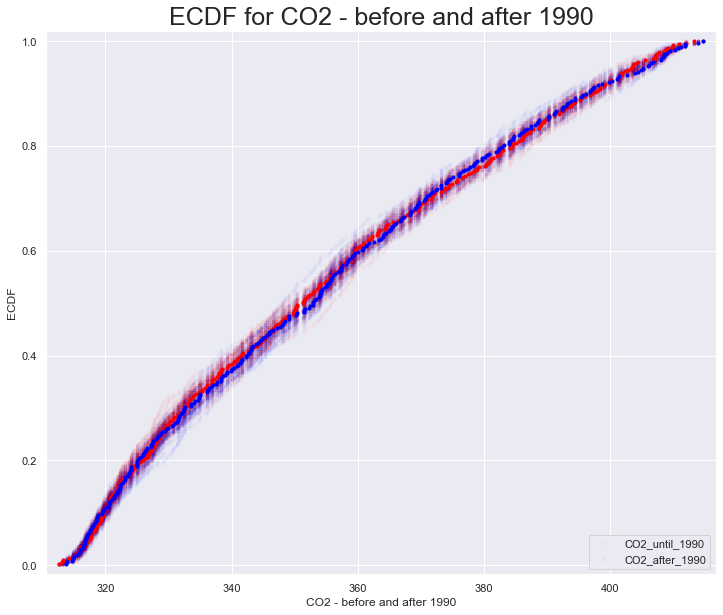

In [49]:
fig = plt.figure(figsize=(12, 10))
plt.title('ECDF for CO2 - before and after 1990', fontsize=25)

for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(CO2_perm[:len(CO2_until_1990)], 
                                                      CO2_perm[len(CO2_until_1990):])

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(CO2_perm[:len(CO2_until_1990)])
x_2, y_2 = ecdf(CO2_perm[len(CO2_until_1990):])
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('CO2 - before and after 1990')
_ = plt.ylabel('ECDF')
plt.legend(('CO2_until_1990', 'CO2_after_1990'), loc='lower right')
plt.show()

The fact that both red and blue curves have a negative second derivative for ECDF shows that the increase of CO2 is accelerating. The reason is that for years closer to 1960 when CO2 concentration was closer to 320 ppm there is a higher slope for ECDF. This means that CO2 levels stayed longer towards 320 ppm than towards 400 ppm.

There is no clear distinction between the two curves and the permutation samples so this diagram alone cannot reject H0

In [50]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [62]:
# Since we are working with time series and the trend is up and accelerating, I shall use 
# for the test statistic the standard deviation not the mean.

def diff_of_sd(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = data_1.std()-data_2.std()

    return diff

# Compute difference of mean for the two series that we want to compare
empirical_diff_sd = diff_of_sd(CO2[CO2['decimal_date'] <= 1990],CO2[CO2['decimal_date'] > 1990])

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(CO2[CO2['decimal_date'] <= 1990], CO2[CO2['decimal_date'] > 1990],
                                 diff_of_sd, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means['CO2_ppm']) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 1.0


This means that there is no statistical difference between CO2 before and after 1990, if the test concerns the standard deviation.

Actually, the trend did not change. The 1990...1995 anomaly represents just a delay. A possible cause is the fall of industry and economy in general in ex-USSR and Eastern Europe due to the 1989...1990 political events. The CO2 increase of CO2 emissions recovered after 5 years or so.

However, the H0 hypothesis cannot be rejected with the techniques used above.